Question in my mind when running this test problem is that if the column density determines the emissivity of the CO or the depth and stopping length determines the emissivity seperately. To test this I am gonna read two cloudy runs one have high hden and low Rstop, the other have low hden but high Rstop, which their column density will be the same overall. I will check the resulting emissivity as a function of column density and resulting Lco.

In [1]:
import sys 
sys.path.append("/scratch/m/murray/dtolgay")
from tools import constants

import numpy as np 
import pandas as pd 

base_dir = "/home/m/murray/dtolgay/scratch/cloudy_runs/z_0/cr_1_CO87_CII_H_O3/cr_1_CO87_CII_H_O3_metallicity_above_minus_2"

import matplotlib.pyplot as plt 

# Functions  

In [2]:
def find_converged_run(cloudy_em_str: np.ndarray, threshold: float = 0) -> np.ndarray:
    """
    To use the coverged value, I will look at the radius values in the file. If radius decreases to initial radius and simulations
    ran one more time starting from the beginning then it means that in the first run it is not coverged and simulation was run again
    Second run gives the converged value. Use the second run.
    """

    index = 0
    for i in range(len(cloudy_em_str) - 1):
        if (cloudy_em_str[i][0] - cloudy_em_str[i + 1][0]) > threshold:
            index = i + 1

    cloudy_em_str = cloudy_em_str[index:]

    return cloudy_em_str

# Main

In [3]:
center_columns = ['log_metallicity', 'log_hden', 'log_turbulence', 'log_isrf', 'log_radius']
flux_columns = [
    "lya", # [erg s^-1 cm^-2]
    "ha", # [erg s^-1 cm^-2]
    "hb", # [erg s^-1 cm^-2]
    "co10", # [erg s^-1 cm^-2]
    "co21", # [erg s^-1 cm^-2]
    "co32", # [erg s^-1 cm^-2]
    "co43", # [erg s^-1 cm^-2]
    "co54", # [erg s^-1 cm^-2]
    "co65", # [erg s^-1 cm^-2]
    "co76", # [erg s^-1 cm^-2]
    "co87", # [erg s^-1 cm^-2]
    "13co", # [erg s^-1 cm^-2]
    "c2", # [erg s^-1 cm^-2]
    "o3_88", # [erg s^-1 cm^-2]
    "o3_5006", # [erg s^-1 cm^-2]
    "o3_4958", # [erg s^-1 cm^-2]    
]
# flux_columns = center_columns + flux_columns


# line_fluxes = pd.DataFrame(
#     np.loadtxt(f"{base_dir}/I_line_values_without_reversing.txt"),
#     columns = flux_columns
# )

line_fluxes = pd.read_csv(f"{base_dir}/F_line_values_without_reversing.csv")

In [4]:
for column in center_columns:
    print(f"{column}: {line_fluxes[column].unique()}")


log_metallicity: [-2.  -1.5 -1.  -0.5  0.   0.5  1. ]
log_hden: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
log_turbulence: [-3. -2. -1.  0.  1.  2.  3.]
log_isrf: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
log_radius: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [5]:

def read_emissivity_file(base_dir, file_props):
    
    emissivity_columns = [
        "depth",
        "lya",    # [erg/cm3/s]
        "ha",
        "hb",
        "co_10",
        "co_21",
        "co_32",
        "co_43",
        "co_54",
        "co_65",
        "co_76",
        "co_87",
        "13co",
        "c2",
        "o3_88", 
        "o3_5006", 
        "o3_4958",    
    ]    
    
    fname = f"hden{file_props['log_hden']:.5f}_metallicity{file_props['log_metallicity']:.5f}_turbulence{file_props['log_turbulence']:.5f}_isrf{file_props['log_isrf']:.5f}_radius{file_props['log_radius']:.5f}"
    
    emissivity_file = np.loadtxt(f"{base_dir}/{fname}/{fname}_em.str")
    emissivity_file = find_converged_run(emissivity_file)
    emissivity_file = pd.DataFrame(emissivity_file, columns=emissivity_columns)
    emissivity_file['column_density'] = emissivity_file['depth'] * (10**file_props['log_hden'] * constants.proton_mass * constants.kg2g) # g / cm2    
    
    return emissivity_file


## New addition

In [6]:
file_props_1 = {
    "log_hden": 1,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -0.5,
    "log_radius": 3,
}
low_hden = read_emissivity_file(base_dir, file_props=file_props_1)


file_props_2 = {
    "log_hden": 3,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -0.5,
    "log_radius": 1,
}
high_hden = read_emissivity_file(base_dir, file_props=file_props_2)



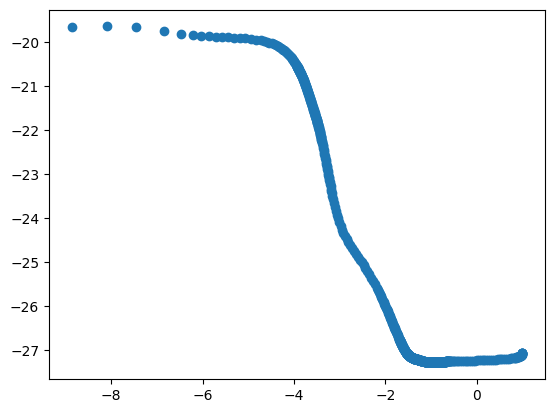

In [18]:
high_hden.columns

depth = high_hden['depth'] / constants.pc2cm

plt.scatter(
    np.log10(depth),
    np.log10(high_hden['ha']),
)

plt.show()

In [7]:
def get_fdir(center: pd.DataFrame) -> str:
    return f"hden{center['log_hden']:.5f}_metallicity{center['log_metallicity']:.5f}_turbulence{center['log_turbulence']:.5f}_isrf{center['log_isrf']:.5f}_radius{center['log_radius']:.5f}"


def read_ovr_file(center: pd.DataFrame, train_data_file_path: str) -> pd.DataFrame:
    
    # Define the path to the ovr file 
    fdir = get_fdir(center)
    path_to_ovr_file = f"{train_data_file_path}/{fdir}/{fdir}.ovr"

    # Read the ovr file
    ovr_file = pd.read_csv(path_to_ovr_file, delim_whitespace=True)
    ovr_file.rename(columns={'#depth': 'depth'}, inplace=True)
    
    return ovr_file


file_props = {
    "log_hden": 1,
    "log_metallicity": 0,
    "log_turbulence": 1,
    "log_isrf": -0.5,
    "log_radius": 3,
}

ovr_file = read_ovr_file(center=file_props, train_data_file_path=base_dir)

ovr_file.columns

/tmp/ipykernel_23910/132539759.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ovr_file = pd.read_csv(path_to_ovr_file, delim_whitespace=True)


Index(['depth', 'Te', 'Htot', 'hden', 'eden', '2H_2/H', 'HI', 'HII', 'HeI',
       'HeII', 'HeIII', 'CO/C', 'C1', 'C2', 'C3', 'C4', 'O1', 'O2', 'O3', 'O4',
       'O5', 'O6', 'H2O/O', 'AV(point)', 'AV(extend)', 'Tau912'],
      dtype='object')

{'log_hden': 1, 'log_metallicity': 0, 'log_turbulence': 1, 'log_isrf': -0.5, 'log_radius': 3}


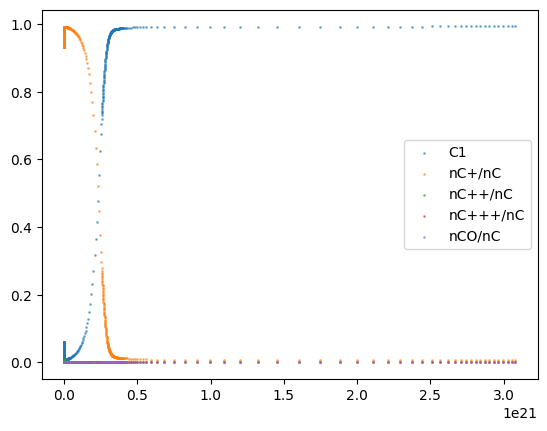

In [8]:
plt.scatter(
    ovr_file['depth'], 
    ovr_file['C1'], 
    label='C1', 
    s=1, 
    alpha=0.5
)

plt.scatter(
    ovr_file['depth'], 
    ovr_file['C2'], 
    label='nC+/nC', 
    s=1, 
    alpha=0.5
)

# Plot the other C lines C3 C4
plt.scatter(
    ovr_file['depth'], 
    ovr_file['C3'], 
    label='nC++/nC', 
    s=1, 
    alpha=0.5
)

plt.scatter(
    ovr_file['depth'], 
    ovr_file['C4'], 
    label='nC+++/nC', 
    s=1, 
    alpha=0.5
)

plt.scatter(
    ovr_file['depth'], 
    ovr_file['CO/C'], 
    label='nCO/nC', 
    s=1, 
    alpha=0.5
)

plt.legend()

print(file_props)

AttributeError: Line2D.set() got an unexpected keyword argument 's'

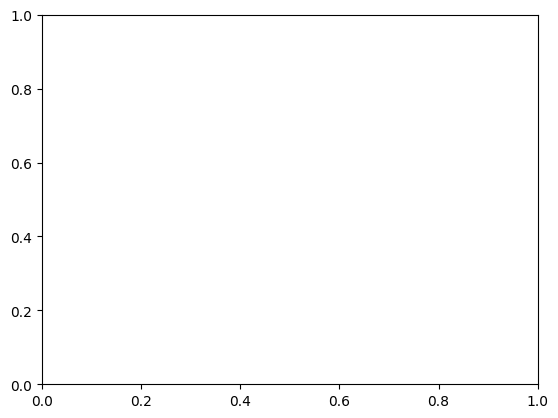

In [10]:
plt.plot(
    ovr_file['depth'], 
    ovr_file['C1'], 
    label='C1', 
    s=1, 
    alpha=0.5
)

plt.plot(
    ovr_file['depth'], 
    ovr_file['C2'], 
    label='nC+/nC', 
    s=1, 
    alpha=0.5
)

# Plot the other C lines C3 C4
plt.plot(
    ovr_file['depth'], 
    ovr_file['C3'], 
    label='nC++/nC', 
    s=1, 
    alpha=0.5
)

plt.plot(
    ovr_file['depth'], 
    ovr_file['C4'], 
    label='nC+++/nC', 
    s=1, 
    alpha=0.5
)

plt.plot(
    ovr_file['depth'], 
    ovr_file['CO/C'], 
    label='nCO/nC', 
    s=1, 
    alpha=0.5
)

plt.legend()

print(file_props)

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(low_hden['column_density'], low_hden['co_10'], label="log(nH)=1 - log(L)=3")
plt.scatter(high_hden['column_density'], high_hden['co_10'], label="log(nH)=3 - log(L)=1")

plt.xlabel(r"Column Density [$gr$ $cm^{-2}$]")
plt.ylabel(r"Emissivity (CO(1-0)) [$erg$ $cm^{-2}$ $s^{-1}$]")

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(loc="upper left")

figure_name = "emissivity_CO10_differentHden_sameColumnDensity.png"
plt.savefig(figure_name)
print(f"{figure_name} saved!")

plt.show()



In [ ]:
plt.scatter(low_hden['depth'], low_hden['co_10'], label="log(nH)=1 - log(L)=3")

plt.xscale("log")

In [ ]:
line_fluxes.columns

In [ ]:
# Print the calculated flux values
def find_indices_of_the_run(line_fluxes, file_props):
    index = np.where(
        (line_fluxes['log_hden'] == np.round(file_props['log_hden'], 1)) &
        (line_fluxes['log_metallicity'] == np.round(file_props['log_metallicity'], 1)) &
        (line_fluxes['log_turbulence'] == np.round(file_props['log_turbulence'], 1)) &
        (line_fluxes['log_isrf'] == np.round(file_props['log_isrf'], 1)) &
        (line_fluxes['log_radius'] == np.round(file_props['log_radius'], 1))
    )[0]
    
    return index

index1 = find_indices_of_the_run(line_fluxes, file_props=file_props_1)
index2 = find_indices_of_the_run(line_fluxes, file_props=file_props_2)

print(f"{line_fluxes.iloc[index1][center_columns + ['co10']]}")
print(f"{line_fluxes.iloc[index2][center_columns + ['co10']]}")


## Read in one galaxy and plot the distribution of Lco as a function of their density and column density

In [ ]:
from tools import functions_readfiles as readfiles # type: ignore

# galaxy_name = "m12i_res7100_md"
# galaxy_type = "zoom_in"
# redshift = "0.0"
# directory = "voronoi_1e5"


redshift = 0.0
directory = "voronoi_1e5"

galaxies = {
    # "m12i_res7100_md": {
    #     "name": "m12i_res7100_md",
    #     "type": "zoom_in",
    #     "redshift": redshift,
    #     "directory": directory,
    #     "data": pd.DataFrame(),
    # },
    # "gal0": {
    #     "name": "gal0",
    #     "type": "firebox",
    #     "redshift": redshift,
    #     "directory": directory,
    #     "data": pd.DataFrame(),
    # },
    "gal20": {
        "name": "gal20",
        "type": "firebox",
        "redshift": redshift,
        "directory": directory,
        "data": pd.DataFrame(),
    },
    # "gal50": {
    #     "name": "gal50",
    #     "type": "firebox",
    #     "redshift": redshift,
    #     "directory": directory,
    #     "data": pd.DataFrame(),
    # },
}


for galaxy_name, galaxy_info in galaxies.items():

    base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"
    galaxy_type = galaxy_info["type"]
    redshift = galaxy_info["redshift"]
    directory = galaxy_info["directory"]
    galaxy_name = galaxy_info["name"]

    fdir = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{directory}/line_emissions_RBFInterpolator_smoothingLength.txt"
    emissions, file_specific_columns_emissions = readfiles.read_interpolated_files_usingFilePath2(path = fdir, interpolation_type = "line_emissions")
    emissions['Nh'] = emissions['hden'] * (emissions['smoothing_length'] * constants.pc2cm)
    

    fdir = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{directory}/abundance_RBFInterpolator_smoothingLength.txt"
    abundance, file_specific_columns_abundance = readfiles.read_interpolated_files_usingFilePath2(path = fdir, interpolation_type = "abundance")

    # merge two dataframes 
    data = emissions.merge(abundance[['index'] + file_specific_columns_abundance], on=["index"], how="inner")

    # Use only the galactic center
    Rgal  = data['x']**2 + data['y']**2 
    Rmax = 5e3
    zmax = 500
    condition = (Rgal < Rmax**2) & (np.abs(data['z']) < zmax)
    data = data[condition].copy()


    # add the galaxy data to the galaxy_info
    galaxy_info["data"] = data


gas_data = galaxies["gal20"]["data"].copy()

# gas_data, file_specific_columns = readfiles.read_interpolated_files_usingFilePath2(path = fdir, interpolation_type = "line_emissions")
# gas_data['Nh'] = gas_data['hden'] * (gas_data['smoothing_length'] * constants.pc2cm)


# # use only certain metallicities 
# # condition = (gas_data['metallicity'] > 1) & (gas_data['metallicity'] < 1.5)
# condition = (gas_data['metallicity'] > -5) & (gas_data['metallicity'] < 5) # Basically all metallicities

# gas_data_filtered = gas_data[condition].copy()

In [ ]:
# use only certain metallicities 
# condition = (gas_data['metallicity'] > 1) & (gas_data['metallicity'] < 1.5)
condition = (gas_data['metallicity'] > -5) & (gas_data['metallicity'] < 5) # Basically all metallicities

gas_data_filtered = gas_data[condition].copy()

In [ ]:

colorbar = np.log10(gas_data_filtered['L_co_10'])
plt.scatter(
    gas_data_filtered['Nh'],
    gas_data_filtered['hden'],
    c=colorbar, 
    cmap='viridis',
    vmin = 0,
    vmax = 4,
    s=0.5,
)
plt.colorbar(label='log(L_co_10)')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Nh [cm^-2]")
plt.ylabel("hden [cm^-3]")
plt.grid(True)


plt.show()


In [ ]:

# colorbar = np.log10(gas_data_filtered['L_co_10'])
# plt.scatter(
#     gas_data_filtered['density'],
#     gas_data_filtered['smoothing_length'],
#     c=colorbar, 
#     cmap='viridis',
#     vmin = 0,
#     vmax = 4,
#     s=0.5,
# )
# plt.colorbar(label='log(L_co_10)')
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("density [g/cm^3]")
# plt.ylabel("smoothing_length [pc]")
# plt.grid(True)


# plt.show()


In [ ]:

# colorbar = np.log10(gas_data_filtered['L_co_10'])
# plt.scatter(
#     gas_data_filtered['Nh'],
#     gas_data_filtered['smoothing_length'],
#     c=colorbar, 
#     cmap='tab20c',
#     vmin = 0,
#     vmax = 5,
#     s=0.5,
# )
# plt.colorbar(label='log(L_co_10)')
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Nh [cm^-2]")
# plt.ylabel("smoothing_length [pc]")
# plt.grid(True)


# plt.show()


In [ ]:

# colorbar = np.log10(gas_data_filtered['L_co_10'])
# plt.scatter(
#     gas_data_filtered['mass'],
#     gas_data_filtered['smoothing_length'],
#     c=colorbar, 
#     cmap='viridis',
#     vmin = 0,
#     vmax = 4,
#     s=0.5,
# )
# plt.colorbar(label='log(L_co_10)')
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("mass [Msun]")
# plt.ylabel("smoothing_length [pc]")
# plt.grid(True)


# plt.show()


In [ ]:

fig, axs = plt.subplots(figsize=(10, 5), dpi=300, ncols=2, nrows=1)

ax = axs[0]
colorbar = np.log10(gas_data_filtered['density'])
sc = ax.scatter(
    gas_data_filtered['Nh'],
    gas_data_filtered['L_co_10'],
    s=0.5,
    c=colorbar,
    cmap='tab20c',
)

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('log(density) [g/cm$^3$]')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\Sigma$ [cm$^{-2}$]")
ax.set_ylabel("Lco_10 [K km/s pc$^2$]")

ax.set_ylim(1e2, 1e5)
ax.grid(True)

##############################################################################################################################

ax = axs[1]
colorbar = np.log10(gas_data_filtered['metallicity'])
sc = ax.scatter(
    gas_data_filtered['Nh'],
    gas_data_filtered['L_co_10'],
    s=0.5,
    c=colorbar,
    cmap='tab20c',
)

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('log(Z) [$Z_\odot$]')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\Sigma$ [cm$^{-2}$]")
ax.set_ylabel("Lco_10 [K km/s pc$^2$]")

ax.set_ylim(1e2, 1e5)
ax.grid(True)

##############################################################################################################################


plt.tight_layout()
plt.show()


![Description](/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/python_files/analyze_hden_metallicity_turbulence_isrf_radius/cloudy/draine_structure_of_pdr.jpeg)


In [ ]:
# Plot the 2d image of the galaxy with the colorbar 

import matplotlib


#################################### Plot
R_max = 7e3 # pc

print("Plotting galaxy")
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# First subplot: x-y axis plot
colorbar_column = "Nh"
sc = axs[0].hist2d(
    x=gas_data_filtered["x"],
    y=gas_data_filtered["y"],
    weights=np.log10(gas_data_filtered[colorbar_column]),
    bins=500,
    norm=matplotlib.colors.LogNorm(),
    range=[[-R_max, R_max], [-R_max, R_max]]
)
# Write the name of the colorbar
cbar = fig.colorbar(sc[3], ax=axs[0])
cbar.set_label(f'log({colorbar_column})')
axs[0].set_title('x-y axis plot')

# Second subplot: z-y axis plot
sc = axs[1].hist2d(
    x=gas_data_filtered["x"],  
    y=gas_data_filtered["y"], 
    weights=np.log10(gas_data_filtered["L_co_10"]),
    bins=500,
    norm=matplotlib.colors.LogNorm(),
    range=[[-R_max, R_max], [-R_max, R_max]],
)
# Write the name of the colorbar
cbar = fig.colorbar(sc[3], ax=axs[1])
cbar.set_label('log(L_co_10) [K km/s pc$^2$]')
axs[1].set_title('x-y axis plot')

# Show the figure
plt.tight_layout()

In [ ]:
from scipy.stats import binned_statistic_2d

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

ax = axs[0]
stat, xedges, yedges, binnumber = binned_statistic_2d(
    gas_data_filtered["x"],
    gas_data_filtered["y"],
    gas_data_filtered["metallicity"],
    statistic='mean',
    bins=1028,
    range=[[-R_max, R_max], [-R_max, R_max]]
)

# Plot with imshow
im = ax.imshow(
    np.log10(stat).T,  # or stat directly if you don’t want log scale
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1)
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("log(average metallicity)")


##############################################################################

ax = axs[1]
stat, xedges, yedges, binnumber = binned_statistic_2d(
    gas_data_filtered["x"],
    gas_data_filtered["y"],
    gas_data_filtered["L_co_10"],
    statistic='sum',
    bins=1028,
    range=[[-R_max, R_max], [-R_max, R_max]]
)

# Plot with imshow
im = ax.imshow(
    np.log10(stat).T,  # or stat directly if you don’t want log scale
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e2)
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('log(L_co_10) [K km/s pc$^2$]')

plt.tight_layout()

In [ ]:
from scipy.stats import binned_statistic_2d

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

ax = axs[0]
stat, xedges, yedges, binnumber = binned_statistic_2d(
    gas_data_filtered["y"],
    gas_data_filtered["z"],
    gas_data_filtered["metallicity"],
    statistic='mean',
    bins=1028,
    range=[[-R_max, R_max], [-R_max, R_max]]
)

# Plot with imshow
im = ax.imshow(
    np.log10(stat).T,  # or stat directly if you don’t want log scale
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1)
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("log(average metallicity)")


##############################################################################

ax = axs[1]
stat, xedges, yedges, binnumber = binned_statistic_2d(
    gas_data_filtered["y"],
    gas_data_filtered["z"],
    gas_data_filtered["L_co_10"],
    statistic='sum',
    bins=1028,
    range=[[-R_max, R_max], [-R_max, R_max]]
)

# Plot with imshow
im = ax.imshow(
    np.log10(stat).T,  # or stat directly if you don’t want log scale
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    norm=matplotlib.colors.LogNorm()
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('log(L_co_10) [K km/s pc$^2$]')

plt.tight_layout()

In [ ]:
# Divide Lco into into bins and calculate the total emission of the bin 
def calculate_bin_emission(gas_data, bin_edges):
    bin_indices = np.digitize(gas_data['L_co_10'], bin_edges)
    bin_emission = np.zeros(len(bin_edges) - 1)
    
    for i in range(len(bin_edges) - 1):
        bin_emission[i] = np.sum(gas_data['L_co_10'][bin_indices == i + 1])
    
    return bin_emission

# Define the bin edges
bin_edges = np.logspace(-5, 7, 50) # [K km/s pc^2]
# Calculate the bin emission
bin_emission = calculate_bin_emission(gas_data, bin_edges)
# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot the histogram
plt.figure(figsize=(10, 5), dpi=300)
plt.hist(gas_data['L_co_10'], bins=bin_edges, alpha=0.5, color='gray', label='Number of Gas Particles in the Bin')
plt.plot(bin_centers, bin_emission, marker='o', linestyle='-', color='red', label='Bin Emission')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Lco_10 [K km/s pc^2]")
plt.ylabel("Total Emission")
plt.grid(True)
plt.legend()


## Using the Draine Formalism to compare the expected Lco with calculated Lco

#### Chapter 19.3.1 is used. Formulas 19.19 and 19.32 is used to calculate the optical depth and Lco luminosity

In [ ]:
mco_theoretical = (gas_data_filtered['mass'] * constants.M_sun2gr) * gas_data_filtered['fCO'] # gr
volume = 4 * np.pi / 3 * (gas_data_filtered['radius'] * constants.pc2cm)**3 # cm3
nco_theoretical = mco_theoretical / volume / constants.mco_gr # cm^-3
optical_depth = 46 * (gas_data_filtered['hden'] / 1000) * (gas_data_filtered['smoothing_length'] * constants.pc2cm / 1e19) * (nco_theoretical / gas_data_filtered['hden'] / 7e-5) * (2 / (gas_data_filtered['turbulence'] * np.sqrt(2)))
Aul = 1.2e-5 # [s^-1]
nu_ul = 115.271 * 1e9 # [Hz]
Lco_theoretical = (4 * np.pi / 3 * gas_data_filtered['smoothing_length']**3) * nco_theoretical * Aul * nu_ul / (1 + 0.5 * optical_depth)


logx = np.linspace(0, 9, 100)
logy = logx + 4

colorbar = np.log10(optical_depth)
plt.scatter(
    gas_data_filtered['L_co_10'],
    Lco_theoretical,
    c=colorbar,
    cmap='tab20c',
    vmin = -1,
    vmax = 2,
    s=0.5,
    label = "Optical Depth Effect is ON",
)
plt.plot(
    10**logx,
    10**logy,
    color='red',
    linestyle='--',
    label='Lco_theoretical = Lco'
)

plt.colorbar(label='log(optical depth)')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Lco_theoretical [arbitrary units]")
plt.xlabel("Lco [K km/s pc^2]")
plt.grid(True)
plt.xlim([1e1, 1e6])
plt.ylim([1e4, 1e10])

plt.legend()
plt.show()

In [ ]:
mco_theoretical = (gas_data_filtered['mass'] * constants.M_sun2gr) * gas_data_filtered['fCO'] # gr
volume = 4 * np.pi / 3 * (gas_data_filtered['radius'] * constants.pc2cm)**3 # cm3
nco_theoretical = mco_theoretical / volume / constants.mco_gr # cm^-3
optical_depth = 46 * (gas_data_filtered['hden'] / 1000) * (gas_data_filtered['smoothing_length'] * constants.pc2cm / 1e19) * (nco_theoretical / gas_data_filtered['hden'] / 7e-5) * (2 / (gas_data_filtered['turbulence'] * np.sqrt(2)))
Aul = 1.2e-5 # [s^-1]
nu_ul = 115.271 * 1e9 # [Hz]
Lco_theoretical = (4 * np.pi / 3 * gas_data_filtered['smoothing_length']**3) * nco_theoretical * Aul * nu_ul 


logx = np.linspace(0, 9, 100)
logy = logx + 4

colorbar = np.log10(optical_depth)
plt.scatter(
    gas_data_filtered['L_co_10'],
    Lco_theoretical,
    c=colorbar,
    cmap='tab20c',
    vmin = -1,
    vmax = 2,
    s=0.5,
    label = "Optical Depth Effect is OFF",
)
plt.plot(
    10**logx,
    10**logy,
    color='red',
    linestyle='--',
    label='Lco_theoretical = Lco',
)

plt.colorbar(label='log(optical depth)')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Lco_theoretical [arbitrary units]")
plt.xlabel("Lco [K km/s pc^2]")
plt.grid(True)
plt.xlim([1e1, 1e6])
plt.ylim([1e4, 1e10])

plt.legend()
plt.show()

#### If optical depth has a huge affect on the CO(1-0) luminosity at high Lco, then the factors contributing to $\tau$ can also be an important variable to explain CO luminosity. Below is to understand the most important factors and correlations between the $\tau$ and gas properties

In [ ]:
mco_theoretical = (gas_data_filtered['mass'] * constants.M_sun2gr) * gas_data_filtered['fCO'] # gr
volume = 4 * np.pi / 3 * (gas_data_filtered['radius'] * constants.pc2cm)**3 # cm3
nco_theoretical = mco_theoretical / volume / constants.mco_gr # cm^-3
optical_depth = 46 * (gas_data_filtered['hden'] / 1000) * (gas_data_filtered['smoothing_length'] * constants.pc2cm / 1e19) * (nco_theoretical / gas_data_filtered['hden'] / 7e-5) * (2 / (gas_data_filtered['turbulence'] * np.sqrt(2)))


In [ ]:
fig, axs = plt.subplots(figsize=(12, 3), dpi=100, ncols=2, nrows=1)

ax = axs[0]
ax.scatter(
    optical_depth, 
    gas_data_filtered['L_co_10'],
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Optical Depth")
ax.set_ylabel("Lco [K km/s pc^2]")
ax.grid(True)

########################################################################

ax = axs[1]
colorbar = np.log10(optical_depth)
sc = ax.scatter(
    gas_data_filtered['Nh'], 
    gas_data_filtered['L_co_10'],
    c=colorbar,
    vmin = -1,
    vmax = 4
)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('log(optical depth)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Nh [cm^-2]")
# ax.set_ylabel("Lco [K km/s pc^2]")
ax.grid(True)
ax.set_ylim([1e4, 1e7])
ax.set_xlim([5e21, 2e23])
